In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


data = pd.read_csv('dataset.csv')
data['class_combined'] = data['type'] + '_' + data['state']

X = data[['name']]
y_stratify = data['class_combined']
random_state = 67

X_temp, X_test, y_temp, y_test_strat = train_test_split(
    X, y_stratify,
    test_size=0.15,
    random_state=random_state,
    stratify=y_stratify
)

X_train, X_val, y_train_strat, y_val_strat = train_test_split(
    X_temp, y_temp,
    test_size=0.176,
    random_state=random_state,
    stratify=y_temp
)

y_train_type  = data.loc[X_train.index, 'type']
y_train_state = data.loc[X_train.index, 'state']

y_val_type  = data.loc[X_val.index, 'type']
y_val_state = data.loc[X_val.index, 'state']

y_test_type  = data.loc[X_test.index, 'type']
y_test_state = data.loc[X_test.index, 'state']

print(f"Train size: {len(X_train)}")
print(f"Val size:   {len(X_val)}")
print(f"Test size:  {len(X_test)}")


Already up to date.
Train size: 2564
Val size:   548
Test size:  550


In [ ]:
import os
import numpy as np
from PIL import Image
import torchvision.transforms as T
import torch

size = 64
normalize = T.Compose([T.ToTensor()])

val_transform = T.Compose([
    T.Resize((size, size)),
    normalize,
])

aug_1 = T.Compose([
    T.Resize((size, size)),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    normalize
])

aug_2 = T.Compose([
    T.Resize((size, size)),
    T.RandomVerticalFlip(0.5),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    normalize
])

aug_3 = T.Compose([
    T.Resize((size, size)),
    T.RandomHorizontalFlip(0.3),
    T.RandomVerticalFlip(0.3),
    T.RandomRotation(5),
    T.ColorJitter(brightness=0.07, contrast=0.07),
    normalize
])

aug_blur = T.Compose([
    T.Resize((size, size)),
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    T.RandomHorizontalFlip(0.4),
    T.ColorJitter(brightness=0.08, contrast=0.08),
    normalize
])

aug_crop = T.Compose([
    T.RandomResizedCrop(size, scale=(0.85, 1.0), ratio=(0.95, 1.05)),
    T.RandomHorizontalFlip(0.4),
    T.RandomRotation(8),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    normalize
])

aug_noise = T.Compose([
    T.Resize((size, size)),
    T.RandomHorizontalFlip(0.3),
    T.ColorJitter(brightness=0.12, contrast=0.12, saturation=0.1),
    T.RandomRotation(7),
    normalize
])

train_transform = [val_transform, aug_1, aug_2, aug_3, aug_blur, aug_crop, aug_noise, aug_3]

def load_images_and_labels(df, labels_type, labels_state, root_dir, transform):
    X_list = []
    y_type_list = []
    y_state_list = []
    
    for i in range(len(df)):
        img_path = os.path.join(root_dir, df.iloc[i]["name"])
        img = Image.open(img_path).convert("RGB")
        
        l_type = labels_type.iloc[i]
        l_state = labels_state.iloc[i]
        
        if isinstance(transform, list):
            for t in transform:
                img_t = t(img)
                X_list.append(img_t.numpy())
                y_type_list.append(l_type)
                y_state_list.append(l_state)
        else:
            img_t = transform(img)
            X_list.append(img_t.numpy())
            y_type_list.append(l_type)
            y_state_list.append(l_state)
            
    return np.stack(X_list, axis=0), np.array(y_type_list), np.array(y_state_list)

root_dir = "datasetV1"

X_train_np, y_train_type_np, y_train_state_np = load_images_and_labels(
    X_train, y_train_type, y_train_state, root_dir, train_transform
)

X_val_np, y_val_type_np, y_val_state_np = load_images_and_labels(
    X_val, y_val_type, y_val_state, root_dir, val_transform
)

X_test_np, y_test_type_np, y_test_state_np = load_images_and_labels(
    X_test, y_test_type, y_test_state, root_dir, val_transform
)

print(X_train_np.shape, y_train_type_np.shape, y_train_state_np.shape)
print(X_val_np.shape,   y_val_type_np.shape,   y_val_state_np.shape)
print(X_test_np.shape,  y_test_type_np.shape,  y_test_state_np.shape)


(20512, 3, 64, 64) (20512,) (20512,)
(548, 3, 64, 64) (548,) (548,)
(550, 3, 64, 64) (550,) (550,)


In [3]:
import cv2
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern

def extract_all_features(X_np, bins=64):
    feats_list = []
    bin_edges = np.linspace(0.0, 1.0, bins + 1)
    
    for i in range(X_np.shape[0]):
        # Prep immagine (CHW -> HWC)
        img = X_np[i].transpose(1, 2, 0)
        img = np.clip(img, 0.0, 1.0)
        img_uint8 = (img * 255).astype(np.uint8)
        
        # 1. Color Hist (HSV)
        img_hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(img_hsv)
        color_feats = []
        for ch in (h.astype(np.float32)/255, s.astype(np.float32)/255, v.astype(np.float32)/255):
            hist, _ = np.histogram(ch, bins=bin_edges, density=True)
            color_feats.append(hist)
            
        # 2. LBP
        gray = rgb2gray(img)
        lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
        lbp_norm = lbp / (lbp.max() + 1e-6)
        lbp_hist, _ = np.histogram(lbp_norm, bins=16, range=(0,1), density=True)
        
        # 3. Morphology
        # Segmentazione su Saturazione
        blur = cv2.GaussianBlur(s, (5, 5), 0)
        _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            c = max(contours, key=cv2.contourArea)
            area = cv2.contourArea(c)
            perimeter = cv2.arcLength(c, True)
            if area > 50 and perimeter > 0:
                circularity = (4 * np.pi * area) / (perimeter ** 2)
                x, y, w, h = cv2.boundingRect(c)
                aspect_ratio = float(w) / h
                extent = area / (w*h)
                hull_area = cv2.contourArea(cv2.convexHull(c))
                solidity = area / hull_area if hull_area > 0 else 0
                morph_feats = [circularity, aspect_ratio, extent, solidity]
            else:
                morph_feats = [0, 0, 0, 0]
        else:
            morph_feats = [0, 0, 0, 0]
            
        feats_list.append(np.concatenate(color_feats + [lbp_hist] + [morph_feats]))
        
    return np.array(feats_list, dtype=np.float32)

X_train_full = extract_all_features(X_train_np)
X_val_full   = extract_all_features(X_val_np)
X_test_full  = extract_all_features(X_test_np)
print("Features Extracted:", X_train_full.shape)


/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.11/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Features Extracted: (20512, 212)


RF Type -> n=100, d=20, Acc=77.55%
RF Type -> n=100, d=30, Acc=77.74%
RF Type -> n=100, d=40, Acc=77.55%
RF Type -> n=200, d=20, Acc=78.28%
RF Type -> n=200, d=30, Acc=78.83%
RF Type -> n=200, d=40, Acc=78.47%
RF Type -> n=300, d=20, Acc=77.92%
RF Type -> n=300, d=30, Acc=78.28%
RF Type -> n=300, d=40, Acc=77.74%

Best Stage 1 Acc: 78.83%


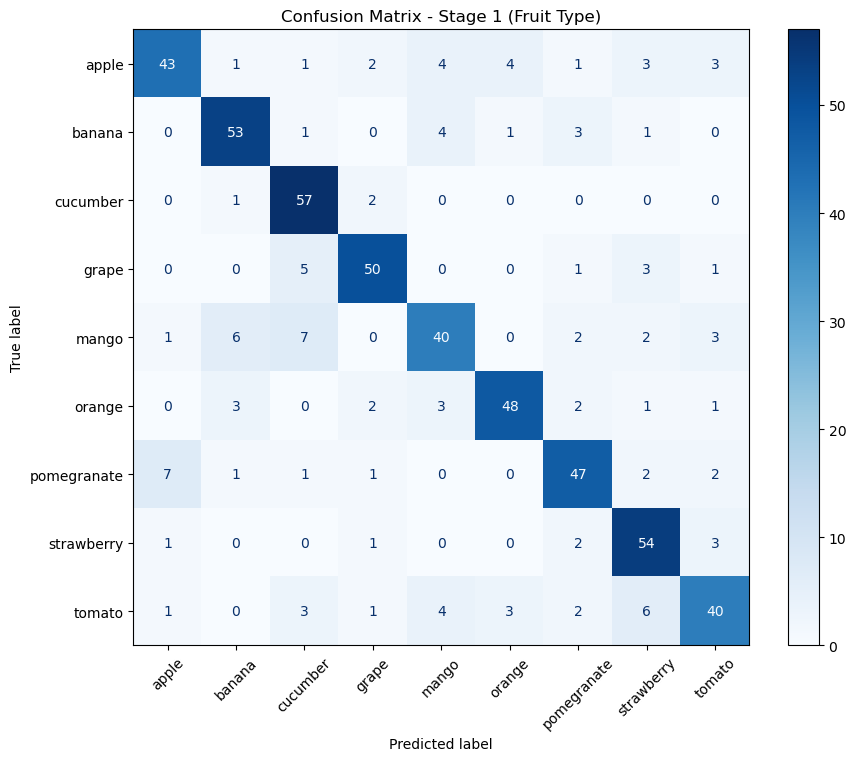

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_full)
X_val_std   = scaler.transform(X_val_full)
X_test_std  = scaler.transform(X_test_full)

# Tuning Stage 1
n_estimators_list = [100, 200, 300]
max_depth_list = [20, 30, 40]
best_acc, best_rf_type = 0.0, None

for n in n_estimators_list:
    for d in max_depth_list:
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features="sqrt", random_state=random_state, n_jobs=-1)
        rf.fit(X_train_std, y_train_type_np)
        acc = rf.score(X_val_std, y_val_type_np)
        print(f"RF Type -> n={n}, d={d}, Acc={acc*100:.2f}%")
        if acc > best_acc:
            best_acc, best_rf_type = acc, rf

print(f"\nBest Stage 1 Acc: {best_acc*100:.2f}%")
y_val_pred_type = best_rf_type.predict(X_val_std)

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val_type_np, y_val_pred_type, labels=best_rf_type.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_type.classes_)
disp.plot(cmap="Blues", xticks_rotation=45, ax=plt.gca())
plt.title("Confusion Matrix - Stage 1 (Fruit Type)")
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

print("\nRF vs SVM for every fruit ===")

fruit_classes = np.unique(y_train_type_np)
models_dict = {} 
final_report = []

rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
svm_params = {'C': [0.1, 1, 10, 20], 'gamma': ['scale', 0.01, 0.001]}

for fruit in fruit_classes:
    print(f"\nProcessing: {fruit}...")
    
    mask_train = (y_train_type_np == fruit)
    X_f_train = X_train_std[mask_train]
    y_f_train = y_train_state_np[mask_train]
    
    mask_val = (y_val_type_np == fruit)
    X_f_val = X_val_std[mask_val]
    y_f_val = y_val_state_np[mask_val]

    # RF
    best_rf_acc = 0
    best_rf_model = None
    for n in rf_params['n_estimators']:
        for d in rf_params['max_depth']:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features='sqrt', random_state=random_state, n_jobs=-1)
            rf.fit(X_f_train, y_f_train)
            acc = rf.score(X_f_val, y_f_val)
            if acc > best_rf_acc:
                best_rf_acc = acc
                best_rf_model = rf

    # SVM
    best_svm_acc = 0
    best_svm_model = None
    best_C = 0
    best_gamma = None
    for C in svm_params['C']:
        for g in svm_params['gamma']:
            svm = SVC(kernel='rbf', C=C, gamma=g, probability=True, random_state=random_state)
            svm.fit(X_f_train, y_f_train)
            acc = svm.score(X_f_val, y_f_val)
            if acc > best_svm_acc:
                best_svm_acc = acc
                best_svm_model = svm
                best_C = C
                best_gamma = g
    
    # Select Winner
    if best_svm_acc > best_rf_acc:
        models_dict[fruit] = best_svm_model
        winner = f"SVM ({best_svm_acc*100:.2f}%, {best_C}, {best_gamma})"
    else:
        models_dict[fruit] = best_rf_model
        winner = f"RF ({best_rf_acc*100:.2f}%)"
        
    print(f"-> Winner: {winner} (RF was {best_rf_acc*100:.2f}%)")


RF vs SVM for every fruit ===

Processing: apple...
-> Winner: SVM (91.94%, 20, 0.001) (RF was 90.32%)

Processing: banana...
-> Winner: RF (96.83%) (RF was 96.83%)

Processing: cucumber...
-> Winner: RF (100.00%) (RF was 100.00%)

Processing: grape...
-> Winner: RF (86.67%) (RF was 86.67%)

Processing: mango...
-> Winner: RF (93.44%) (RF was 93.44%)

Processing: orange...
-> Winner: RF (96.67%) (RF was 96.67%)

Processing: pomegranate...
-> Winner: SVM (88.52%, 1, 0.01) (RF was 86.89%)

Processing: strawberry...
-> Winner: SVM (95.08%, 10, 0.001) (RF was 91.80%)

Processing: tomato...
-> Winner: RF (86.67%) (RF was 86.67%)


In [6]:
y_val_pred_type = best_rf_type.predict(X_val_std)

final_predictions = []

for i in range(len(X_val_std)):
    pred_fruit = y_val_pred_type[i]
    specialist = models_dict[pred_fruit]
    sample_feat = X_val_std[i].reshape(1, -1)
    pred_state = specialist.predict(sample_feat)[0]
    final_predictions.append(f"{pred_fruit}_{pred_state}")

final_predictions = np.array(final_predictions)

y_val_combined = np.array([f"{t}_{s}" for t, s in zip(y_val_type_np, y_val_state_np)])

acc_final = accuracy_score(y_val_combined, final_predictions)
print(f"FINAL HIERARCHICAL ACCURACY: {acc_final*100:.2f}%")

print(classification_report(y_val_combined, final_predictions))


FINAL HIERARCHICAL ACCURACY: 74.82%
                     precision    recall  f1-score   support

      apple_healthy       0.79      0.72      0.75        32
       apple_rotten       0.75      0.60      0.67        30
     banana_healthy       0.84      0.84      0.84        32
      banana_rotten       0.76      0.81      0.78        31
   cucumber_healthy       0.77      1.00      0.87        30
    cucumber_rotten       0.75      0.90      0.82        30
      grape_healthy       0.73      0.80      0.76        30
       grape_rotten       0.77      0.67      0.71        30
      mango_healthy       0.69      0.67      0.68        30
       mango_rotten       0.69      0.58      0.63        31
     orange_healthy       0.90      0.87      0.88        30
      orange_rotten       0.78      0.70      0.74        30
pomegranate_healthy       0.81      0.71      0.76        31
 pomegranate_rotten       0.58      0.63      0.60        30
 strawberry_healthy       0.72      0.87      0.